# Code to generate figure 3 in the publication
Analysis of sensitive enzymes and reactions in the model simulations of protein overexpression

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import os
import sys

from PAModelpy.configuration import Config
from PAModelpy.EnzymeSectors import ActiveEnzymeSector, UnusedEnzymeSector, TransEnzymeSector, CustomSector
from PAModelpy.Enzyme import Enzyme

sys.path.append('../Scripts/')
from pam_generation import set_up_ecoli_pam

DATA_DIR = os.path.join(os.path.split(os.getcwd())[0], 'Data')
eGFP_MW = 2.8*1e4 #g/mol
eGFP_RANGE = np.arange(0,0.15,0.01)
GLC_CONC = 9.81 #mmol_glc/gcdw/h
eGFP_BEINICK_DATA_PATH = os.path.join(DATA_DIR, 'eGFP_expression_Bienick2014.xls')
BIOMASS_RXNID = Config.BIOMASS_REACTION

Loading PAModelpy modules


## sensitivities of GECKO and PAM

### 1 Usefull functions

In [2]:
def calculate_sensitivities(pamodel):
    #initialize objects for storing information
    results_df = pd.DataFrame(columns = ['eGFP', 'mu', 'mu_normalized'])
    Ccac = [] #capacity allocation coefficients
    Cfac = [] #flux allocation coefficients
    x_axis_fac = []
    x_axis_cac = []
    y_axis = []
    fluxes = []
    
    # #set glucose uptake rate
    # pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
    #                                         lower_bound = -100, upper_bound = 0)
    
    #set glucose uptake rate
    pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                            lower_bound = -GLC_CONC, upper_bound = -GLC_CONC)
    
    
    for conc in eGFP_RANGE:
        print('Running simulations with the following eGFP concentration: ', conc, 'mmol/g_cdw/h')
        with pamodel:
            #change eGFP concentration
            pamodel.constraints['eGFP_min'].ub = -conc*1e3
            sol_pam = pamodel.optimize()
            #check if simulation is optimal
            if pamodel.solver.status == 'optimal': 
                y_axis += [conc]
                
                # save data
                fluxes.append(sol_pam.fluxes) # flux distributions
    
                # calculate normalized growth rate
                mu = pamodel.reactions.get_by_id(BIOMASS_RXNID).flux
                if conc == 0:
                    mu_normalized = 1
                    mu_wt = mu
                else:
                    mu_normalized = mu/mu_wt
                results_df.loc[len(results_df)] = [conc,mu, mu_normalized]
    
                #save sensitivities
                Ccac_new = list()
                capacity_coeff = pamodel.capacity_allocation_coefficients
                for cac in ['UB', 'LB', 'EC_max_f','EC_min_f', 'EC_max_b','EC_min_b', 'sector']:
                    if cac == 'EC_min_f':
                        Ccac_new += [-coef for coef in capacity_coeff[capacity_coeff['constraint'] == cac].coefficient.to_list()]
                    else:
                        Ccac_new += capacity_coeff[capacity_coeff['constraint'] == cac].coefficient.to_list()
                
                Ccac += [Ccac_new]
                
                flux_coeff = pamodel.flux_allocation_coefficients
                Cfac_new = list()
                for fac in ['rxn', 'enzyme', 'sector']:
                    Cfac_new += flux_coeff[flux_coeff['constraint'] == fac].coefficient.to_list()
                Cfac += [Cfac_new]
                
                print('Sum of capacity allocation coefficients: \t \t \t \t \t \t \t', round(sum(Ccac_new),6))
                print('Sum of flux allocation coefficients: \t \t \t \t \t \t \t \t', round(sum(Cfac_new),6), '\n')

    return {'Ccac':Ccac, 'Cfac':Cfac, 'y_axis':y_axis, 'fluxes':fluxes, 'capacity coefficients':capacity_coeff, 
            'flux coefficients':flux_coeff, 'results': results_df}
            

In [3]:
def parse_x_axis_heatmap(capacity_coeff, flux_coeff):
    x_axis_fac = []
    x_axis_cac = []
    
    for cc in ['UB', 'LB', 'EC_max_f','EC_min_f', 'EC_max_b','EC_min_b', 'sector']:
        if cc == 'UB' or cc == 'LB':
            x_axis_cac += [coef+'_'+ cc for coef in capacity_coeff[capacity_coeff['constraint'] == cc].rxn_id.to_list()]
        else:
            x_axis_cac += [coef+'_'+ cc for coef in capacity_coeff[
            capacity_coeff['constraint'] == cc].enzyme_id.to_list()]
    
    for fac in ['rxn', 'enzyme', 'sector']:
        if fac == 'rxn':
            x_axis_fac += flux_coeff[flux_coeff['constraint'] == fac].rxn_id.to_list()
        else:
            x_axis_fac += flux_coeff[
                flux_coeff['constraint'] == fac].enzyme_id.to_list()
    return x_axis_cac, x_axis_fac

In [27]:
def make_heatmap_subfigure(results, cac_matrix, fac_matrix, x_cac, x_fac, yaxis, fig, grdspc, ylabels = True, cbar =True, 
                           fontsize = 16, vmin = -1.5, vmax = 1.5, annotate = None, phenotype_data = None):
    # fig = plt.figure()

    if cbar:
        gs = gridspec.GridSpecFromSubplotSpec(2, 2, width_ratios=[len(yaxis), 1], 
                                            height_ratios=[len(x_cac), len(x_fac)], hspace =0, subplot_spec=grdspc)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, width_ratios=[len(yaxis)], 
                                            height_ratios=[len(x_cac), len(x_fac)], hspace =0, subplot_spec=grdspc)

    # gs = gridspec.GridSpec(3, 2, width_ratios=[len(yaxis), 1], height_ratios=[1,len(x_cac), len(x_fac)], hspace =0)
    
    fac_ax = fig.add_subplot(gs[1,0]) #FAC heatmap
    cac_ax = fig.add_subplot(gs[0,0],sharex = fac_ax) #CAC heatmap
    if cbar:
        cbar_ax = fig.add_subplot(gs[0:,1]) #colorbar

    #add annotation for subfigure (A or B)
    if annotate is not None:
        cac_ax.annotate(annotate, xy=(2, 1), xycoords='data',
            xytext=(-0.05,1.1), textcoords='axes fraction',
            va='top', ha='left', fontsize = fontsize+5, weight = 'bold')

    #CAC heatmap
    im_cac = cac_ax.imshow(cac_matrix, aspect="auto", cmap="viridis", vmin = vmin, vmax =vmax)
    cac_ax.set_yticks(np.arange(len(x_cac)), labels=x_cac, fontsize =fontsize)
    cac_ax.xaxis.set_visible(False)
    if ylabels:
        cac_ax.set_ylabel('CAC', fontsize = fontsize*1.5)

    #Make line between CAC and FAC data more clear
    axis = 'bottom'
    cac_ax.spines[axis].set_linewidth(10)
    cac_ax.spines[axis].set_color("black")
    cac_ax.spines[axis].set_zorder(0)
    
    #FAC heatmap
    im_fac = fac_ax.imshow(fac_matrix, aspect="auto", cmap="viridis", vmin = vmin, vmax =vmax)
    fac_ax.set_yticks(np.arange(len(x_fac)), labels=x_fac, fontsize =fontsize)
    fac_ax.set_xticks(np.arange(len(yaxis)),labels = yaxis, fontsize =fontsize, rotation=45, ha='right')
    # fac_ax.set_xlabel('Glucose uptake rate [$mmol_{glc}/g_{CDW}/h$]', fontsize = fontsize)
    if ylabels:
        fac_ax.set_ylabel('FAC', fontsize = fontsize*1.5)
        
    #colorbar
    if cbar:
        cbar_ax.xaxis.set_visible(False)
        # cbar_ax.yaxis.set_visible(False)
        make_scaled_colorbar(ax=cbar_ax, vmin=vmin, vmax=vmax, fig = fig, fontsize = fontsize)

    return fig

In [5]:
def make_scaled_colorbar(ax, fig, vmin =-1, vmax = 1, fontsize = 16, cbarlabel = 'Allocation Coefficient'):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = matplotlib.cm.ScalarMappable(cmap="viridis", norm = norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax =ax, cax=ax, shrink = 1, fraction = 1)
    #setting the fontsize of the colourbar
    cbar.set_label(cbarlabel,fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.yaxis.get_offset_text().set(size=fontsize)

In [6]:
#adjust labels for better readibility
def adjust_heatmap_labels(labels):
    new_labels = labels.copy()

    for i, label in enumerate(labels):
        if label =='EX_glc__D_e' or label[:-3] == 'EX_glc__D_e':
            if label[-1] == 'B': new_labels[i] = 'EX_glc_'+label[-2:]
            else: new_labels[i] = 'EX_glc'
        if label == 'TotalProteinConstraint_sector':
            new_labels[i] = 'Protein pool'
        if label == 'eGFP_EC_min_f':
            new_labels[i] = 'eGFP_min'
        if label[0].isdigit(): #all enzyme ids start with a digit
            if label == '2.7.3.9':
                new_labels[i] = 'Glucose\ntransport'
            else:
                rxn_ids = pamodel.get_reactions_with_enzyme_id(label)
                rxn_name = pamodel.reactions.get_by_id(rxn_ids[-1]).name.split('(')[0]
                new_labels[i] = '\n'.join([part for part in rxn_name.split(' ')])
    return new_labels

In [7]:
def find_nonzero_sensitivities(Cv, x_axis):
    indices = []
    for row in Cv:
        for index, coeff in enumerate(row):
            if abs(coeff)>0.09 and index not in indices:
                indices.append(index)
    
    coeff_nonzero = []
    for row in Cv:
        coeff_nonzero.append([coeff for i, coeff in enumerate(row) if i in indices])
    x_coeff_nonzero = [coeff for i, coeff in enumerate(x_axis) if i in indices]

    return coeff_nonzero, x_coeff_nonzero

In [8]:
def find_top5_sensitivities(Cv, x_axis, yaxis):
    #top 5 enzymes per simulation
    Cv_df = pd.DataFrame(Cv, columns = x_axis, index =yaxis)
    largest = list()
    for i, row in Cv_df.iterrows():
        top5 = abs(row).nlargest()        
        if top5.iloc[0]:
            largest += [index for index, value in top5.items() if abs(value)>0.05]
            print([index for index, value in top5.items() if abs(value)>0.05])
    
    #remove duplicates
    largest_list = list(set(largest))

    #extract non duplicate top5 enzymes
    top5_df = Cv_df[largest_list].T.drop_duplicates().sort_index()
    largest_list = top5_df.index.values

    top5_matrix = [list(row) for i, row in top5_df.iterrows()]
    return top5_matrix, largest_list


### 2 Run PAM simulations with default protein content
#### 2.1 Build the model and add the eGFP protein

In [9]:
pamodel = set_up_ecoli_pam()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-07
Read LP format model from file /tmp/tmpzsbldyg5.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:220: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model iML1515



In [10]:
eGFP_enzyme = Enzyme('eGFP', {}, molmass = 1e6) #molmass of 1e6 to get a direct relation between enzyme concentration and total protein content
pamodel.add_enzymes([eGFP_enzyme])

#### 2.3 Run simulations for different eGFP concentrations

In [11]:
results_pam = calculate_sensitivities(pamodel)
x_axis_cac_pam,x_axis_fac_pam = parse_x_axis_heatmap(results_pam['capacity coefficients'], results_pam['flux coefficients'])

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000776
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.81015 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000815
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.804318 

Running simulations with the following eGFP concentration:  0.02 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000846
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.799957 

Running simulations with the following eGFP concentration:  0.03 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000879
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.79525 

Running simulations with the following eGFP concentration:  0.04 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000916
Sum of flux allocation coefficients: 

In [12]:
cac_nonzero_pam, x_cac_nonzero_pam = find_nonzero_sensitivities(results_pam['Ccac'], x_axis = x_axis_cac_pam)
fac_nonzero_pam, x_fac_nonzero_pam = find_nonzero_sensitivities(results_pam['Cfac'], x_axis = x_axis_fac_pam)

In [13]:
cac_nonzero_pam_t = np.transpose(np.array(cac_nonzero_pam))
fac_nonzero_pam_t = np.transpose(np.array(fac_nonzero_pam))

In [14]:
cac_top5_pam, x_cac_top5_pam = find_top5_sensitivities(results_pam['Ccac'], x_axis = x_axis_cac_pam, yaxis = eGFP_RANGE)
fac_top5_pam, x_fac_top5_pam = find_top5_sensitivities(results_pam['Cfac'], x_axis = x_axis_fac_pam, yaxis = eGFP_RANGE)

['EX_glc__D_e_LB', 'TotalProteinConstraint_sector']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC

### 3. Run PAM simulations with total protein content of 0.31 g/g_cdw
#### 3.1 Build PAModel

In [15]:
pamodel_inc = set_up_ecoli_pam(total_protein =0.31)
#add eGFP protein
pamodel_inc.add_enzymes([eGFP_enzyme])

Read LP format model from file /tmp/tmp3de5d78u.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.31 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:220: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model iML1515



#### 3.2 Run simulations for different eGFP concentrations

In [16]:
results_inc = calculate_sensitivities(pamodel_inc)
x_axis_cac_inc,x_axis_fac_inc = parse_x_axis_heatmap(results_inc['capacity coefficients'], results_inc['flux coefficients'])
cac_nonzero_inc, x_cac_nonzero_inc = find_nonzero_sensitivities(results_inc['Ccac'], x_axis = x_axis_cac_inc)
fac_nonzero_inc, x_fac_nonzero_inc = find_nonzero_sensitivities(results_inc['Cfac'], x_axis = x_axis_fac_inc)

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000087
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.985872 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.000087
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.98549 

Running simulations with the following eGFP concentration:  0.02 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.00099
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.839438 

Running simulations with the following eGFP concentration:  0.03 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.001158
Sum of flux allocation coefficients: 	 	 	 	 	 	 	 	 0.816028 

Running simulations with the following eGFP concentration:  0.04 mmol/g_cdw/h
Sum of capacity allocation coefficients: 	 	 	 	 	 	 	 1.001197
Sum of flux allocation coefficients: 

In [17]:
cac_nonzero_inc_t = np.transpose(np.array(cac_nonzero_inc))
fac_nonzero_inc_t = np.transpose(np.array(fac_nonzero_inc))

In [18]:
cac_top5_inc, x_cac_top5_inc = find_top5_sensitivities(results_inc['Ccac'], x_axis = x_axis_cac_inc, yaxis = eGFP_RANGE)
fac_top5_inc, x_fac_top5_inc = find_top5_sensitivities(results_inc['Cfac'], x_axis = x_axis_fac_inc, yaxis = eGFP_RANGE)

['EX_glc__D_e_LB']
['EX_glc__D_e_LB']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f']
['EX_glc__D_e_LB', 'TotalProteinConstraint_sector', 'eGFP_EC_min_f', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector', 'ATPM_LB']
['EX_glc__D_e_LB', 'eGFP_EC_min_f', 'TotalProteinConstraint_sector',

### 4 Create plot

#### 4.1 Load phenotypic data

In [19]:
# load phenotype data from excel file
pt_data = pd.read_excel(os.path.join(DATA_DIR, 'Ecoli_phenotypes','Ecoli_phenotypes_py_rev.xls'), sheet_name='Yields', index_col=None)
pt_data['EX_glc__D_e'] = -pt_data['EX_glc__D_e']

# # extract reaction specific data 
# rxn_to_pt = {}
# rxn_transform = {
#     'EX_ac_e': 'Acetate_OUT',
#     'EX_co2_e': 'CO2_OUT',
#     'EX_o2_e': 'O2_IN',
#     'BIOMASS_Ecoli_core_w_GAM': 'mu'
# }
# for rxn_id, pt_id in rxn_transform.items():
#     rxn_to_pt[rxn_id] = pt_data[['Glucose_IN', pt_id]].dropna().rename(columns={pt_id: rxn_id})


/tmp/ipykernel_15228/2357036964.py:45: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('Figure3_sensitivities_protein-overproduction.png', dpi =200,bbox_inches='tight')


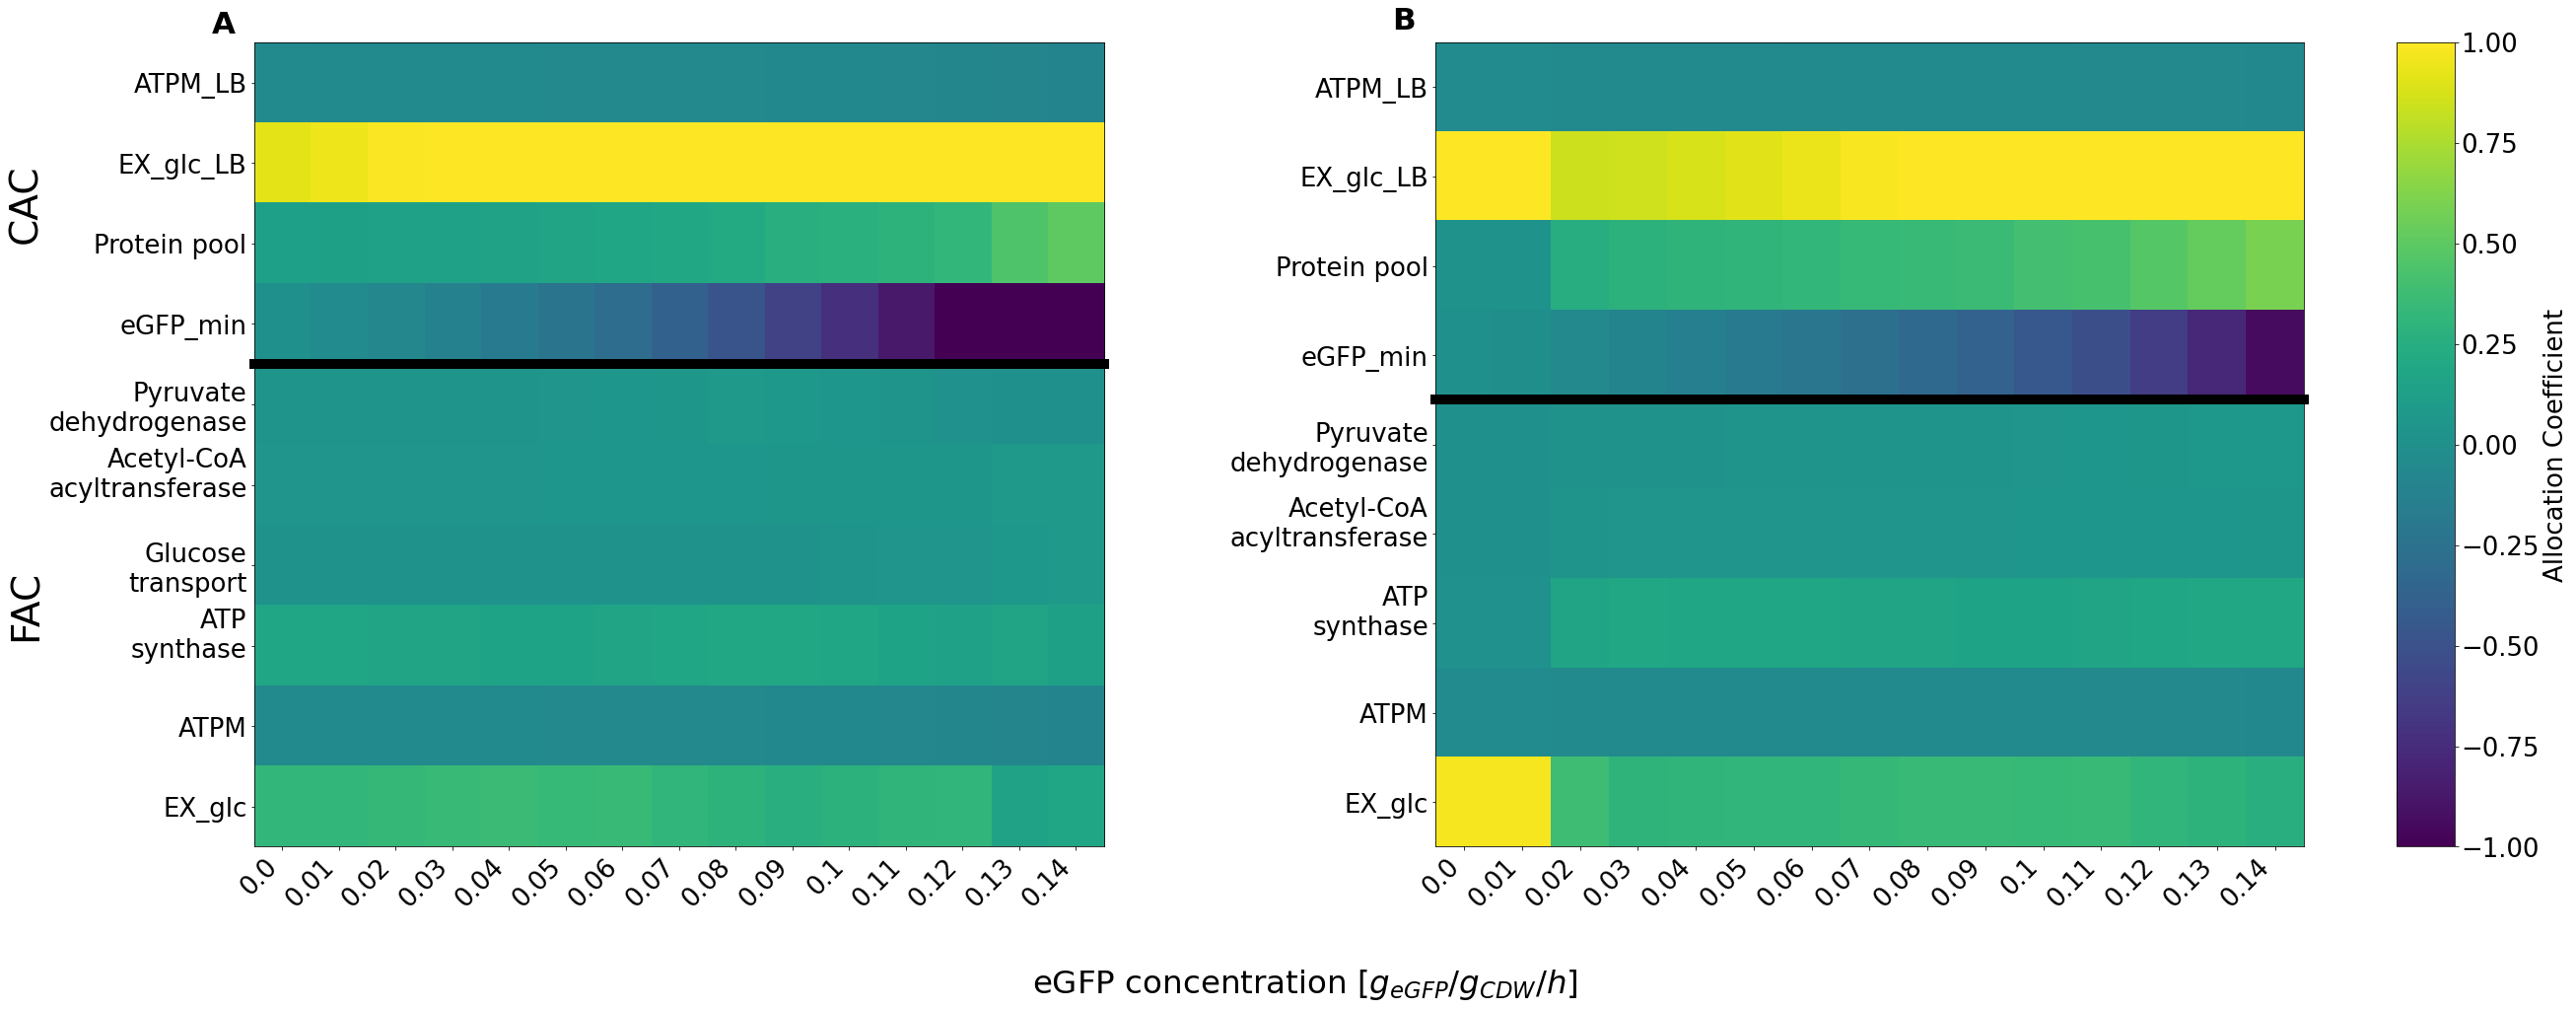

In [28]:
#create 1 big plot
fontsize = 26
vmin =-1
vmax=1
width = 40
height = 15

# gridspec inside gridspec
fig = plt.figure(layout = 'constrained')

gs0 = gridspec.GridSpec(1, 14, figure=fig, wspace = 25)
gs_pam = gs0[:6]
gs_inc = gs0[7:]

#adjust labels for better readibility
x_cac_label_pam = adjust_heatmap_labels(x_cac_top5_pam)
x_fac_label_pam = adjust_heatmap_labels(x_fac_top5_pam)


fig_pam = make_heatmap_subfigure(results = results_pam, cac_matrix=cac_top5_pam, fac_matrix =fac_top5_pam,cbar =False,
                                   x_cac=x_cac_label_pam, x_fac=x_fac_label_pam, yaxis = eGFP_RANGE, fig = fig, grdspc = gs_pam,
                                   annotate = 'A', vmin = vmin, vmax=vmax, fontsize = fontsize)

# adjust labels for better readibility
x_cac_label_inc = adjust_heatmap_labels(x_cac_top5_inc)
x_fac_label_inc = adjust_heatmap_labels(x_fac_top5_inc)


fig_inc = make_heatmap_subfigure(results = results_inc, cac_matrix=cac_top5_inc, fac_matrix =fac_top5_inc, ylabels = False,
                                   x_cac=x_cac_label_inc, x_fac=x_fac_label_inc, yaxis = eGFP_RANGE, fig = fig, grdspc=gs_inc, 
                                 annotate = 'B',  vmin = vmin, vmax=vmax, fontsize = fontsize)

#set common x axis title
ax_xlabel = fig.add_subplot(gs0[0, :2])
ax_xlabel.set_xticks([])
ax_xlabel.set_yticks([])
ax_xlabel.set_frame_on(False)
ax_xlabel.set_xlabel('eGFP concentration [$g_{eGFP}/g_{CDW}/h$]', fontsize = fontsize*1.25)
ax_xlabel.xaxis.set_label_coords(6, -.15)

fig.set_figwidth(width)
fig.set_figheight(height)
fig.align_labels()

fig.savefig('Figure3_sensitivities_protein-overproduction.png', dpi =200,bbox_inches='tight')

In [22]:
for rxnid, flux in results_pam['fluxes'][-1].items():
    if rxnid in x_fac_top5_pam:
        print(rxnid, flux)

EX_glc__D_e -9.81000000005588
ATPM 6.85999999998603


In [23]:
fac_top5_pam

[[0.03172040626869701,
  0.03407918356358403,
  0.03537201489880454,
  0.03676726194484004,
  0.03827759639080436,
  0.04280299289212809,
  0.048433733789867546,
  0.058913692864266044,
  0.07063251417747986,
  0.0652488738685942,
  0.050786667207297666,
  0.034044416214310376,
  0.014972335446973989,
  0.0,
  0.0],
 [0.04403525595305061,
  0.0446408172725496,
  0.04464081727254959,
  0.04464081727254959,
  0.04464081727254959,
  0.0471087304864912,
  0.04710873048649121,
  0.05069708579767998,
  0.05360631842444461,
  0.05671510224576086,
  0.05671510224576086,
  0.05671510224576086,
  0.058370523459060866,
  0.07232610314086214,
  0.07232610314086281],
 [0.018222171213179976,
  0.019144491223627977,
  0.01987389580146009,
  0.020661082462906113,
  0.02151320046850506,
  0.023689922773638124,
  0.0248170024416529,
  0.026344199990348097,
  0.023905460561294133,
  0.02851744053270343,
  0.03370800331347627,
  0.03971688611440587,
  0.046005161467277206,
  0.06276948223442666,
  0.07135

In [31]:
x_fac_label_pam

array(['Pyruvate\ndehydrogenase', 'Acetyl-CoA\nacyltransferase\n',
       'Glucose\ntransport', 'ATP\nsynthase\n', 'ATPM', 'EX_glc'],
      dtype=object)

## 4.2 plot normalized growth rate as function of eGFP concentration
similar to what has been done by Alter et al. (2021)

In [23]:
#get eGFP data from Bienick et al. (2014)
egfp_exp = pd.read_excel(eGFP_BEINICK_DATA_PATH, sheet_name='eGFPvsMu')
mu_wt = 0.75

egfp_exp['mu_normalized'] = egfp_exp['Growth rate'].apply(lambda x: x/mu_wt)
egfp_exp['mu_error_normalized'] = egfp_exp['Growth rate error'].apply(lambda x: x/mu_wt)

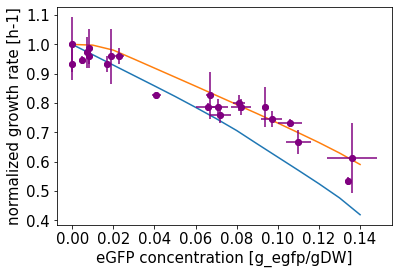

In [33]:
fig, ax = plt.subplots()
ax.plot(results_pam['results']['eGFP'], results_pam['results']['mu_normalized'])
ax.plot(results_inc['results']['eGFP'], results_inc['results']['mu_normalized'])

ax.scatter(egfp_exp['eGFP concentration'], egfp_exp['mu_normalized'],
                   color='purple', marker='o', s=30, linewidths=1.3,
                   facecolors=None, zorder=0,
                   label='Data')
ax.errorbar(egfp_exp['eGFP concentration'], egfp_exp['mu_normalized'], 
            yerr= egfp_exp['mu_error_normalized'], xerr = egfp_exp['eGFP concentration error'],
           fmt="o", color='purple')


# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.set_xlabel('eGFP concentration [g_egfp/gDW]', fontsize = 15)
ax.set_ylabel('normalized growth rate [h-1]', fontsize =15)

plt.show()

fig.savefig('SuppFigure3_eGFP-normalized_mu.png', dpi =200,bbox_inches='tight')

## 4.3 plot predicted exchange rates
similar to what has been done by Alter et al. (2021)

/tmp/ipykernel_9363/3494849565.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


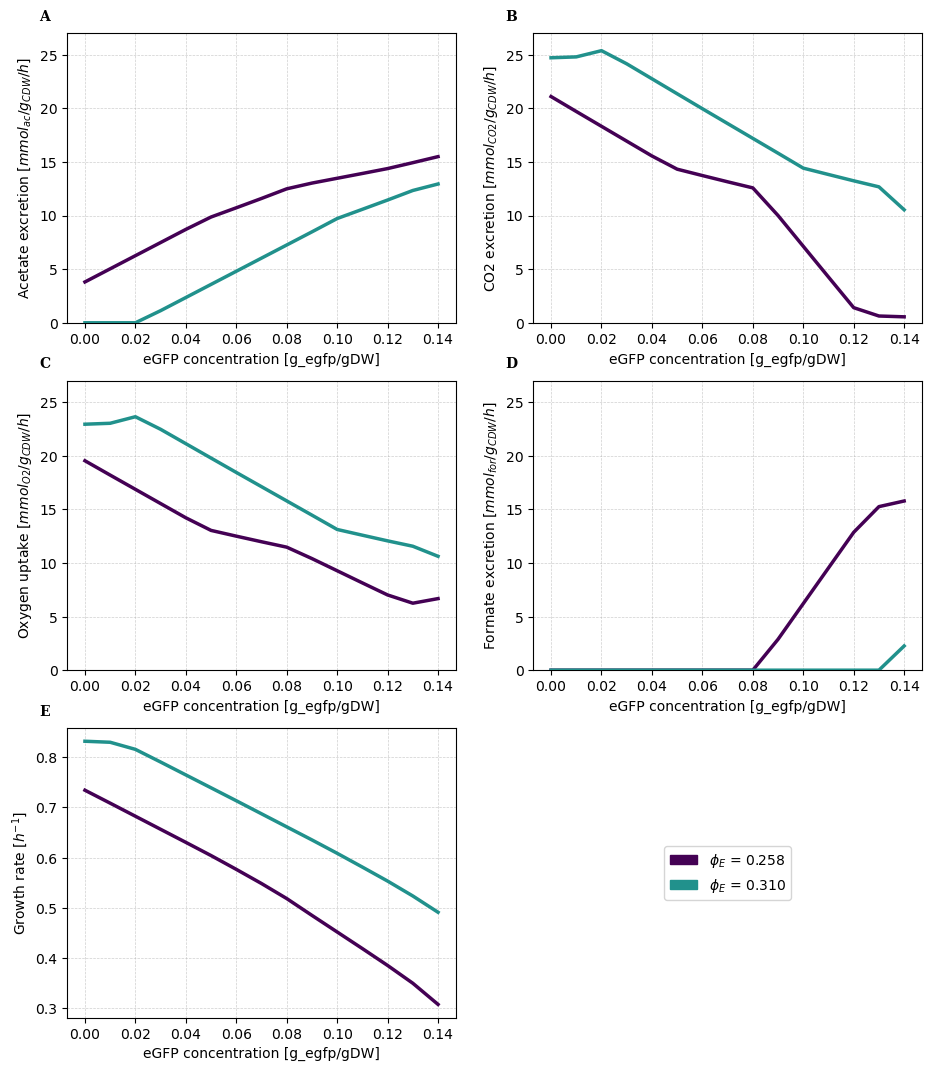

In [68]:
#plot flux changes with eGFP concentration
import matplotlib.transforms as mtransforms
fig, axs = plt.subplot_mosaic([['A', 'B'], ['C', 'D'], ['E', '']],
                              layout='constrained', dpi =100)
for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', weight = 'bold')

rxn_id = ['EX_ac_e', 'EX_co2_e', 'EX_o2_e', 'EX_for_e', BIOMASS_RXNID]
ylabels = ['Acetate excretion [$mmol_{ac}/g_{CDW}/h$]', 'CO2 excretion [$mmol_{CO2}/g_{CDW}/h$]', 
           'Oxygen uptake [$mmol_{O2}/g_{CDW}/h]$', 'Formate excretion [$mmol_{for}/g_{CDW}/h$]','Growth rate [$h^{-1}$]']
# fig, axs = plt.subplots(2,2, dpi=100)
for i,r in enumerate(rxn_id):
    ax_label = ['A', 'B', 'C', 'D', 'E'][i]
    ax = axs[ax_label]
    if r != BIOMASS_RXNID:
        ax.set_ylim([0,27])
    # plot simulation
    line_pam = ax.plot(eGFP_RANGE, [abs(f[r]) for f in results_pam['fluxes']],
            label='Simulation phi_e = 0.258', linewidth=2.5,
            zorder=5, color ='#440154')
    
    # plot simulation with increases protein capacity
    line_inc = ax.plot(eGFP_RANGE, [abs(f[r]) for f in results_inc['fluxes']],
            label='Simulation phi_e = 0.31', linewidth=2.5,
            zorder=5, color = '#21918c')
   
    
    # options
    ax.set_xlabel('eGFP concentration [g_egfp/gDW]')
    ax.set_ylabel(ylabels[i])
    # set grid
    ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.6   )
    ax.set_axisbelow(True)
    # show legend
    # ax.legend(fontsize=8, edgecolor='white', facecolor='white', framealpha=1)
    
axs[''].axis('off')
# Manually create legend handles (patches)
blue_patch = matplotlib.patches.Patch(color='#440154', label='$\phi_{E}$ = 0.258')
orange_patch = matplotlib.patches.Patch(color='#21918c', label='$\phi_{E}$ = 0.310')

# Add legend to bottom-right ax
axs[''].legend(handles=[blue_patch, orange_patch], loc='center')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.set_figheight(13)
fig.set_figwidth(10)
fig.savefig('SuppFigure3_simulated-physiology.png')


In [26]:
pamodel.constraints['eGFP_min'].ub = -0.5
pamodel.update

for cons in pamodel.enzymes.get_by_id('eGFP')._constraints.values():
    print(cons.expression, cons.ub, cons.name)
enz_var = pamodel.enzyme_variables.get_by_id('eGFP')

pamodel.constraints[pamodel.TOTAL_PROTEIN_CONSTRAINT_ID].get_linear_coefficients([enz_var.forward_variable])

AttributeError: 'PAModel' object has no attribute 'update'